# Network per channel

As we dive more precisely into the topic, we now create a more robust dataset:

* each input is an image of size `(C, W, H)`. On each channel, there is a grayscale sliced image. So, 
  * the first `C/3` channels are sliced images along x axis
  * the following `C/3` channels are sliced images along x axis
  * the last `C/3` channels are sliced images along x axis
* each output is list of fabric descriptors

If we take `C=3`, we can use a pretrained VGG model. Indeed, this model is trained on RGB images, which have 3 channels.

# Importing the dataframe

Firstly, we initialize wandb. It is a tool that allows to store the losses and retrieve the deframe. Otherwise, you can directly access locally the dataframe on your computer.

In [ ]:
!pip install wandb --upgrade

We import all the useful packages.

In [52]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import wandb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
from torchvision import models as pretrained_models
from torchvision import transforms, utils
from tqdm import tqdm

from custom_datasets import dataset
from custom_models import models
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api

log_wandb = False

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {device}")


[INFO]: Computation device: cpu


We initialize a wandb run, that will save our metrics

In [53]:
if log_wandb:
    import wandb

    wandb_api.login()
    run = wandb.init(
        project="microstructure-reconstruction",
        group="NChannel Network",
        job_type="test",
    )


Parameters of our run:

In [54]:
if log_wandb:
    config = wandb.config
else:
    config = {}

config["job_type"] = run.job_type if "run" in locals() else "test"
config["train_val_split"] = 0.7
config["seed"] = 42
config["batch_size"] = 64
config["learning_rate"] = 0.0001
config["device"] = device
config["momentum"] = 0.9
config["architecture"] = "pretrained VGG"
config["input_width"] = 64
config["weight_decay"] = 0.0000
config["epochs"] = 0
config["frac_sample"] = 1
config["total_layers"] = 22
config["fixed_layers"] = 0
config["log_wandb"] = log_wandb
torch.manual_seed(config["seed"])
pl.seed_everything(config["seed"])


Global seed set to 42


42

We retrieve the dataframe containing the descriptors. This can locally be done on your computer.

In [78]:
reload(dataset)
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        config,
        repo_path,
        train_df = None,
        test_df = None,
        
    ):
        super().__init__()
        self.config = config
        self.repo_path = repo_path
        self.train_df = train_df.convert_dtypes() if train_df is not None else None
        self.test_df = test_df.convert_dtypes() if train_df is not None else None

        if self.config["log_wandb"]:
            if self.train_df is None:
                self.training_data_at = wandb.Api().artifact(
                    "matiasetcheverry/microstructure-reconstruction/"
                    + "train_df"
                )
            if self.test_df is None:
                self.test_data_at = wandb.Api().artifact(
                    "matiasetcheverry/microstructure-reconstruction/"
                    + "test_df"
                )

        self.transform = transforms.Compose(
            [
                transforms.CenterCrop(207),
                transforms.Resize(
                    (self.config["input_width"], self.config["input_width"])
                ),
                transforms.ToTensor(),
                transforms.GaussianBlur(kernel_size=3, sigma=0.5),
            ]
        )

    def prepare_data(self):
        if self.config["log_wandb"]:
            if self.train_df is None:
                self.training_data_at.download()
            if self.test_df is None:
                self.test_data_at.download()
    
    def _init_df_wandb(self):
        if self.train_df is None:
            self.train_df = wandb_api.convert_table_to_dataframe(
                self.training_data_at.get("fabrics")
            )
            self.train_df["photos"] = self.train_df["photos"].apply(
            func=lambda photo_paths: [
                str(self.repo_path / Path(x)) for x in photo_paths
            ]
        )
        if self.test_df is None:
            self.test_df = wandb_api.convert_table_to_dataframe(
                self.test_data_at.get("fabrics")
            )
            self.test_df["photos"] = self.test_df["photos"].apply(
                func=lambda photo_paths: [
                    str(self.repo_path / Path(x)) for x in photo_paths
                ]
            )

    def _init_df_local(self):
        fabrics_df = pd.read_csv(self.repo_path / "REV1_600/fabrics.txt")
        path_to_slices = self.repo_path / "REV1_600/REV1_600Slices"
        fabrics_df["photos"] = fabrics_df["id"].apply(
            func=dataframe_reformat.associate_rev_id_to_its_images,
            args=(path_to_slices, 10),
        )
        fabrics_df = fabrics_df[fabrics_df.photos.str.len().gt(0)]
        fabrics_df["photos"] = fabrics_df["photos"].apply(func=lambda x: sorted(x))
        train_df, test_df = train_test_split(
            fabrics_df,
            train_size=config["train_val_split"],
            random_state=config["seed"],
            shuffle=True,
        )
        if self.train_df is None:
            self.train_df = train_df.reset_index(drop=True)
        if self.test_df is None:
            self.test_df = test_df.reset_index(drop=True)

    def init_df(self):
        if self.config["log_wandb"]:
            self._init_df_wandb()
        else:
            self._init_df_local()

    def setup(self, stage):
        self.init_df()
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaler.partial_fit(self.train_df.iloc[:, 1:-1])
        self.scaler.partial_fit(self.test_df.iloc[:, 1:-1])
        normalized_train_df = deepcopy(self.train_df)
        normalized_train_df.iloc[:, 1:-1] = self.scaler.transform(
            self.train_df.iloc[:, 1:-1]
        )
        normalized_test_df = deepcopy(self.test_df)
        normalized_test_df.iloc[:, 1:-1] = self.scaler.transform(
            self.test_df.iloc[:, 1:-1]
        )

        self.train_dataset = dataset.NChannelPhotosDataset(
            normalized_train_df, nb_input_photos_per_plane=1, transform=self.transform
        )
        self.validation_dataset = dataset.NChannelPhotosDataset(
            normalized_test_df,
            nb_input_photos_per_plane=1,
            transform=self.transform,
        )
        self.targets = self.test_df.iloc[:, 1:-1].to_numpy()

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.config["batch_size"],
            shuffle=True,
            **kwargs,
        )

    def val_dataloader(self):
        return DataLoader(
            self.validation_dataset,
            batch_size=self.config["batch_size"],
            shuffle=False,
            **kwargs,
        )

    def test_dataloader(self):
        return self.val_dataloader()

    def predict_dataloader(self):
        return DataLoader(
            [image for image, _ in self.validation_dataset],
            batch_size=self.config["batch_size"],
            shuffle=False,
            **kwargs,
        )

dm = DataModule(config, repo_path)


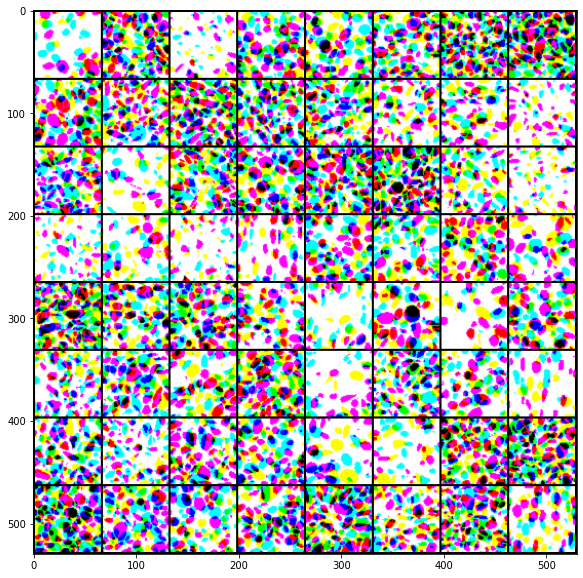

In [79]:
dm.prepare_data()
dm.setup(stage="fit")
first_batch = next(iter(dm.train_dataloader()))

images, labels = first_batch[0], first_batch[1]
grid = utils.make_grid(images)
fig = plt.figure(figsize=(40, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  50 non-null     string 
 1   orientation-0_mean  50 non-null     Float64
 2   orientation-1_mean  50 non-null     Float64
 3   orientation-2_mean  50 non-null     Float64
 4   orientation-3_mean  50 non-null     Float64
 5   orientation-4_mean  50 non-null     Float64
 6   orientation-5_mean  50 non-null     Float64
 7   orientation-0_std   50 non-null     Float64
 8   orientation-1_std   50 non-null     Float64
 9   orientation-2_std   50 non-null     Float64
 10  orientation-3_std   50 non-null     Float64
 11  orientation-4_std   50 non-null     Float64
 12  orientation-5_std   50 non-null     Float64
 13  aspectratio-0_mean  50 non-null     Float64
 14  aspectratio-1_mean  50 non-null     Float64
 15  aspectratio-0_std   50 non-null     Float64
 16  aspectrati

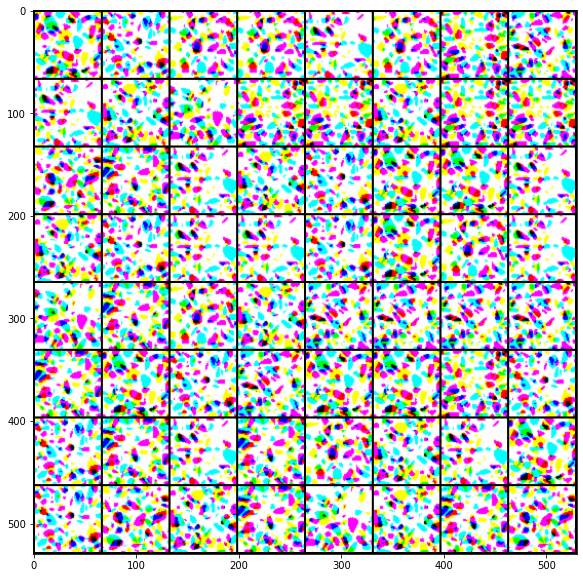

In [89]:
newdf = pd.DataFrame(np.repeat(dm.train_df.iloc[0:1, :].values, 50, axis=0), columns=dm.train_df.columns).convert_dtypes()
dm2 = DataModule(config, repo_path, train_df=newdf)
dm2.prepare_data()
dm2.setup(stage="fit")
print(dm2.train_df.info())
first_batch = next(iter(dm2.train_dataloader()))

images, labels = first_batch[0], first_batch[1]
grid = utils.make_grid(images)
fig = plt.figure(figsize=(40, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()

# Network definition

The next step is to define our model. This model is inspired by VGG11:

* we define several convulational blocks.
* each of this block is sequence of:
  * convulational layer with `kernel_size=3, padding=1`
  * activation function, here it is the `ReLU`
  * max pooling layer with `kernel_size=2, stride=2` which aims at reducing the size of the convolutional layers

In [48]:
class PreTrainedVGG(models.BaseModel):
    def __init__(self, config, scaler=None):
        super().__init__(config)

        self.config = config
        self.config["model_type"] = type(self)
        self.scaler = scaler

        self.configure_model()
        self.configure_criterion()
        self.configure_metrics()

    def configure_model(self):
        assert self.config["total_layers"] >= self.config["fixed_layers"]
        vgg = pretrained_models.vgg11(pretrained=True)
        self.layers = nn.Sequential(
            *(list(vgg.features.children())[: self.config["total_layers"]])
        )
        for idx, child in enumerate(self.layers.children()):
            if idx < self.config["fixed_layers"]:
                for param in child.parameters():
                    param.requires_grad = False
            else:
                reset_parameters = getattr(child, "reset_parameters", None)
                if callable(reset_parameters):
                    child.reset_parameters()
        nb_channels, width, a = (
            self.layers(
                torch.rand(
                    (1, 3, self.config["input_width"], self.config["input_width"])
                )
            )
            .squeeze()
            .shape
        )
        self.layers.add_module(str(len(self.layers)), nn.BatchNorm2d(nb_channels))
        input_fc = int(width ** 2 * nb_channels)
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=input_fc, out_features=512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=512, out_features=23),
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


config["total_layers"] = 40
model = PreTrainedVGG(config)
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
model(torch.rand((1, 3, config["input_width"], config["input_width"])))


PreTrainedVGG(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

tensor([[ 0.0274, -0.0918,  0.0212,  0.0297, -0.1208, -0.0514, -0.0434,  0.0112,
          0.0089, -0.0500, -0.0355, -0.0233,  0.0294, -0.1041,  0.0487,  0.0427,
          0.0161,  0.0150,  0.0023, -0.0244,  0.0972,  0.0328,  0.0196]],
       grad_fn=<AddmmBackward0>)

# Checkpoint

We had 2 checkpoints to our training:

* one for saving our model every time we have a minimum in the validation loss 
* one for saving the model's and data module script

In [128]:
model_checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(
    dirpath=run.dir if "run" in locals() else "",
    filename="{epoch}-{val_loss:.3f}",
    monitor="val_loss",
    mode="min",
    verbose=True,
    save_last=True,
)

script_checkpoint = training.ScriptCheckpoint(
    dirpath=run.dir if "run" in locals() else "",
)

callbacks = [script_checkpoint]
log = None
if config["job_type"] == "train":
    callbacks.append(model_checkpoint)
    print(f"[INFO]: saving models.")
if config["job_type"] == "debug":
    log = "all"


# Training

We then train our model.

In [129]:
if config["log_wandb"]:
    wandb_logger = pl.loggers.WandbLogger()
    wandb_logger.watch(model, log=log, log_graph=True)
else:
    wandb_logger = None
trainer = pl.Trainer(
    max_epochs=3,
    callbacks=callbacks,
    logger=wandb_logger,
    devices="auto",
    accelerator="auto",
    limit_train_batches=2,
    limit_val_batches=1,
    log_every_n_steps=1,
)
trainer.fit(
    model,
    datamodule=dm,
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/matias/.pyenv/versions/3.9.8/envs/gt/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name          | Type       | Params
---------------------------------------------
0 | layers        | Sequential | 1.7 M 
1 | linear_layers | Sequential | 8.7 M 
2 | criterion     | L1Loss     | 0     
---------------------------------------------
10.4 M    Trainable params
0         Non-trainable params
10.4 M    Total params
41.598    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]